# Building Recurrent Models for Splicing Prediction with Synthetic and Genomic Data, Part 2: Deeper Models, More Data

Yesterday we tried to construct a convolutional-recurrent neural network to predict alternative 5' splice ratios.

I then tried to use the same model to predict splicing in genomic sequences. This performed terribly. However, maybe we could still predict the changes in expression from SNPs.

Now, we'll try to do something similar to HAL. The output of the final dense layer is a score much like the one given by the softmax regression from HAL, which becomes a probability after being passed into a sigmoid function. This means that we can use a similar technique to predict delta-PSI.

In [1]:
%matplotlib inline
from keras.models import model_from_json
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils

import numpy as np
import matplotlib.pyplot as plt
import cPickle
from sklearn.metrics import r2_score

Using Theano backend.


## Loading Data

In [4]:
X_train, X_test, Y_train, Y_test = nn_utils.load_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

## Model 1: Exon Only, Two Convolutional Layers

In [10]:
num_filters = [64,32]
filter_length = [6,4]


model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu', input_dim=4))
model1.add(LSTM(output_dim=num_filters[-1]))
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [11]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 570s - loss: 0.5780 - acc: 1.0000 - val_loss: 0.5467 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 571s - loss: 0.5358 - acc: 1.0000 - val_loss: 0.5316 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 566s - loss: 0.5253 - acc: 1.0000 - val_loss: 0.5216 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 566s - loss: 0.5203 - acc: 1.0000 - val_loss: 0.5230 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 580s - loss: 0.5166 - acc: 1.0000 - val_loss: 0.5319 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 578s - loss: 0.5142 - acc: 1.0000 - val_loss: 0.5198 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 559s - loss: 0.5121 - acc: 1.0000 - val_loss: 0.5105 - val_acc: 1.0000
Epoch 8/50
212035/212035 [======

In [13]:
model1.save_weights('../data/convolutional-recurrent-2.h5', overwrite=True)
model_json = model1.to_json()
with open('../data/convolutional-recurrent-2-model.json', 'w') as f:
    f.write(model_json)

In [15]:
predictions = model1.predict(X1_test)

In [16]:
r2_score(Y2_test, predictions)

0.61283777052240629

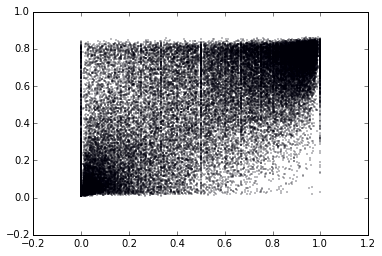

In [21]:
plt.scatter(Y2_test, predictions, s=0.1)
plt.show()

## Testing Model Performance for SNP Effect Prediction

To test this model's performance on SNPs... we could randomly generate mutations in intronic sequences for alt-5' genomic events, and compare this model's prediction with HAL's prediction.

Also we could look at actual mutations that happen in alt-5' exons, and see how the effects compare.

I added data from the Cell 2015 paper in the data folder. mmc2.tsv contains event sequences and some predictions. mmc3.tsv contains HAL predictions.

In [1]:
import pandas as pd